## Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops , local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix , f1_score , precision_score , recall_score
import seaborn as sns

## Reading Data

In [2]:

CLASSES = ["flooded", "non-flooded"]
def load_data(data_path):
    data = []
    labels = []
    for c in CLASSES:
        path = os.path.join(data_path, c)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img_array, (512, 512))
            data.append(img_array)
            labels.append(CLASSES.index(c))
    return data, labels

# Load data
data, labels = load_data("./Dataset")

## Splitting Data

In [3]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.15, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# X_test = np.array(X_test)
# y_test = np.array(y_test)

## Preprocessing

In [4]:
# contrast enhancement
def contrast_enhancement(img):
    # Split the image into individual channels
    channels = cv2.split(img)

    # Apply histogram equalization to each channel
    equalized_channels = []
    for channel in channels:
        equalized_channel = cv2.equalizeHist(channel)
        equalized_channels.append(equalized_channel)

    # Merge the equalized channels back into an RGB image
    equalized_image = cv2.merge(equalized_channels)
    return equalized_image  

def preprocess_images(images):
    processed_images = []
    for image in images:
        image = contrast_enhancement(image)
        processed_images.append(image)
    return np.array(processed_images)

X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)
#X_test = preprocess_images(X_test)

## Features Extraction

In [5]:
def water_index(img):
    water_idx = (img[:,:,1] - img[:,:,0]) / (img[:,:,1] + img[:,:,0]+0.000000001)
    water_idx = np.array(water_idx)
    avg_water_idx = np.mean(water_idx)
    return avg_water_idx

def GLCM(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    avg_contrast = np.mean(contrast)
    avg_dissimilarity = np.mean(dissimilarity)
    avg_homogeneity = np.mean(homogeneity)
    avg_energy = np.mean(energy)
    avg_correlation = np.mean(correlation)

    return avg_contrast, avg_dissimilarity, avg_homogeneity, avg_energy, avg_correlation


def color_histogram(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    pixels = img.reshape(-1, 3)

    k = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centers = cv2.kmeans(pixels.astype(np.float32), k, None, criteria, 10, flags)

    hist, _ = np.histogram(labels, bins=np.arange(k+1))
    hist = hist / float(hist.sum())

    return hist

def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8 , 3)
    hist, _ = np.histogram(lbp.ravel(), bins=np.linspace(0, 255, 257))
    bins = np.array_split(hist, 8)
    features = [np.sum(b) for b in bins]
    return features

def extract_features(images):
    features = []
    for img in images:
        water_idx = water_index(img)
        contrast, dissimilarity, homogeneity, energy, correlation = GLCM(img)
        hist = color_histogram(img)
        lbp = extract_lbp(img)
        features.append([water_idx, contrast, dissimilarity, homogeneity, energy, correlation,lbp[0], lbp[1], lbp[2], lbp[3], lbp[4], lbp[5], lbp[6], lbp[7], hist[0], hist[1], hist[2], hist[3], hist[4]])
    features = np.array(features)   
    return features

X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)
#X_test_features = extract_features(X_test)

print(X_train_features.shape)
print(X_val_features.shape)
#print(X_test_features.shape)


(783, 19)
(139, 19)


## Models Training

In [79]:
models = [RandomForestClassifier(n_estimators=80, max_depth=8, random_state=42) , AdaBoostClassifier(n_estimators=100 ,learning_rate=0.2 , random_state=42) , GaussianNB(), xgb.XGBClassifier(max_depth=15 , n_estimators=150 , learning_rate=0.2, random_state=42)]
modelsNames = ['Random Forest' , 'AdaBoost' , 'Naive Bayes' , 'XGBoost']
for i , model in enumerate(models):
    if modelsNames[i] == 'Naive Bayes':
        model.fit(X_train_features[:,1:13], y_train)
    else:
        model.fit(X_train_features, y_train)

## Models Evaluation

Evauation of Random Forest
Accuracy :  0.9136690647482014
              precision    recall  f1-score   support

           0       0.97      0.87      0.92        78
           1       0.86      0.97      0.91        61

    accuracy                           0.91       139
   macro avg       0.91      0.92      0.91       139
weighted avg       0.92      0.91      0.91       139

Precision :  0.9132505175983436
Recall :  0.9195039932744851
Ommision Error :  0.08049600672551493
Commission Error :  0.08674948240165636
F1 Score :  0.9133056133056132
Confusion Matrix : 
[[68 10]
 [ 2 59]]


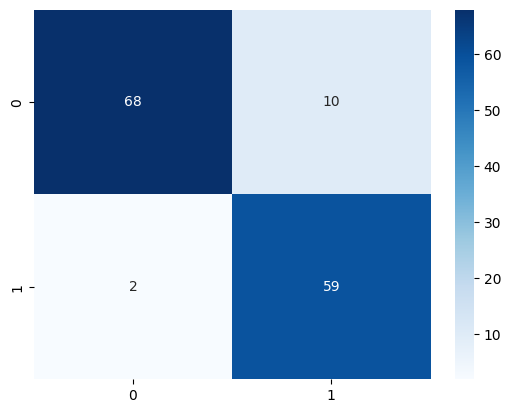

Evauation of AdaBoost
Accuracy :  0.841726618705036
              precision    recall  f1-score   support

           0       0.94      0.77      0.85        78
           1       0.76      0.93      0.84        61

    accuracy                           0.84       139
   macro avg       0.85      0.85      0.84       139
weighted avg       0.86      0.84      0.84       139

Precision :  0.84875
Recall :  0.851828499369483
Ommision Error :  0.14817150063051698
Commission Error :  0.15125
F1 Score :  0.8416528583264291
Confusion Matrix : 
[[60 18]
 [ 4 57]]


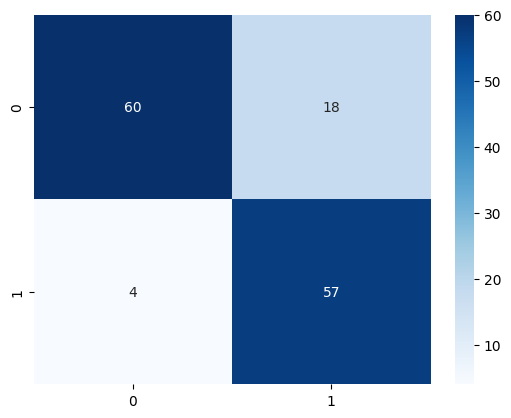

Evauation of Naive Bayes
Accuracy :  0.8129496402877698
              precision    recall  f1-score   support

           0       0.87      0.78      0.82        78
           1       0.75      0.85      0.80        61

    accuracy                           0.81       139
   macro avg       0.81      0.82      0.81       139
weighted avg       0.82      0.81      0.81       139

Precision :  0.8125258799171843
Recall :  0.8172551492223623
Ommision Error :  0.1827448507776377
Commission Error :  0.18747412008281572
F1 Score :  0.8121621621621622
Confusion Matrix : 
[[61 17]
 [ 9 52]]


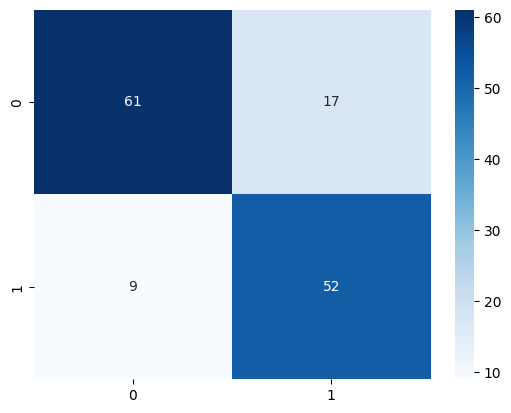

Evauation of XGBoost
Accuracy :  0.9064748201438849
              precision    recall  f1-score   support

           0       0.99      0.85      0.91        78
           1       0.83      0.98      0.90        61

    accuracy                           0.91       139
   macro avg       0.91      0.91      0.91       139
weighted avg       0.92      0.91      0.91       139

Precision :  0.9092039800995024
Recall :  0.9148802017654476
Ommision Error :  0.0851197982345524
Commission Error :  0.09079601990049757
F1 Score :  0.9063002333419756
Confusion Matrix : 
[[66 12]
 [ 1 60]]


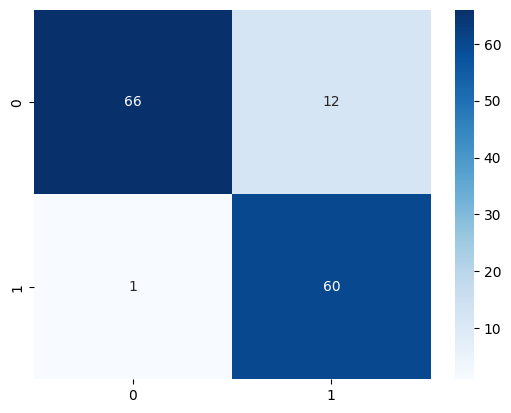

In [80]:
for i , model in enumerate(models):
    print("Evauation of " + modelsNames[i])

    if modelsNames[i] == 'Naive Bayes':
        y_pred = model.predict(X_val_features[:,1:13])
    else:
        y_pred = model.predict(X_val_features)

    # accuracy
    print("Accuracy : " , accuracy_score(y_val, y_pred))

    # classification report
    print(classification_report(y_val, y_pred))

    # precision
    print("Precision : " , precision_score(y_val, y_pred, average='macro'))
    
    # recall
    print("Recall : " , recall_score(y_val, y_pred, average='macro'))

    # ommision error
    print("Ommision Error : " , 1 - recall_score(y_val, y_pred, average='macro'))

    # commission error
    print("Commission Error : " , 1 - precision_score(y_val, y_pred, average='macro'))
    
    # f1 score
    print("F1 Score : " , f1_score(y_val, y_pred, average='macro'))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix : ")
    print(cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()